In [1]:
import numpy as np
import keras
from keras import layers
import pandas as pd
from PIL import Image
import os
import time
import ast
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [2]:

size = 128
num_labels = 7

encoder = OneHotEncoder()
encoder.fit([[0],[1],[2],[3],[4],[5],[6]])

df = pd.read_csv("ClassificationData2.csv")[["path", "labels", "class"]]
df

,path,labels,class
0,./Project/XN_Project/renders/intraventricular/...,"[1, 0, 0, 1, 0, 0]",1
1,./Project/XN_Project/renders/intraventricular/...,"[1, 0, 0, 1, 0, 0]",1
2,./Project/XN_Project/renders/intraventricular/...,"[1, 0, 0, 1, 0, 0]",1
3,./Project/XN_Project/renders/intraventricular/...,"[1, 0, 0, 1, 0, 0]",1
4,./Project/XN_Project/renders/intraventricular/...,"[1, 0, 0, 1, 0, 0]",1
...,...,...,...
11382,./Project/XN_Project/renders/normal/normal/bra...,"[0, 0, 0, 0, 0, 0]",0
11383,./Project/XN_Project/renders/normal/normal/max...,"[0, 0, 0, 0, 0, 0]",0
11384,./Project/XN_Project/renders/normal/normal/bra...,"[0, 0, 0, 0, 0, 0]",0
11385,./Project/XN_Project/renders/normal/normal/bra...,"[0, 0, 0, 0, 0, 0]",0


In [3]:
images = np.array(df['path'])
print(images.shape)

(11387,)


In [4]:
# Select random datapoints
image_paths = np.random.choice(images, size=11387, replace=False)
image_paths.shape

(11387,)

In [5]:
data = []
labels = []
start = time.time()
for path in image_paths:
    try:
        img = Image.open(path)
    except:
        #Skip if image not found
        continue
    img = img.resize((size,size))
    img = np.array(img)
    if(img.shape == (size,size, 3)):
        data.append(np.array(img))

#         s = df[df['path'] == path]['labels'].iat[0]
#         labels.append(ast.literal_eval(s)[1:])
        s = df[df['path'] == path]['class'].iat[0]
        labels.append(encoder.transform([[s]]).toarray())

end = time.time()
print(end - start)
data, labels = np.array(data), np.array(labels)
print(data.shape, labels.shape)

78.7165093421936
(11387, 128, 128, 3) (11387, 1, 7)


In [6]:
from sklearn.model_selection import train_test_split 
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(data,labels, 
                                   random_state=104,  
                                   test_size=0.2,  
                                   shuffle=True) 

X_test, X_CV, y_test, y_CV = train_test_split(X_test,y_test, 
                                   random_state=104,  
                                   test_size=0.5,  
                                   shuffle=True) 


## Normalize training data to be between 0 and 1, we have to typecast it as a float to do so.
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_CV = X_CV.astype('float32')
X_train /= 255.
X_test /= 255.
X_CV /= 255.

# Reshape data
X_train = X_train.reshape(-1,size,size, 3)
X_test = X_test.reshape(-1,size,size, 3)
X_CV = X_CV.reshape(-1,size,size, 3)

print("80:10:10 split for train/test/CV")
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('X_CV:', X_CV.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)
print('y_CV:', y_CV.shape)

80:10:10 split for train/test/CV
X_train: (9109, 128, 128, 3)
X_test: (1139, 128, 128, 3)
X_CV: (1139, 128, 128, 3)
y_train: (9109, 1, 7)
y_test: (1139, 1, 7)
y_CV: (1139, 1, 7)


In [8]:
# Randomly augment training images
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]


def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

for i in range(X_train.shape[0]):
    X_train[i] = img_augmentation(X_train[i])

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from keras.layers import Dense, BatchNormalization, Input, ReLU, GlobalMaxPooling2D, Conv2D, ZeroPadding2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [18]:
# # Creates a convolutional neural network model for classifying images
# # Model is built on top of the MobileNetV3Large architecture if specified, using the predefined "imagenet" weights,
# # and also using the softmax activation function
# # Given image_size to cater the model to the size of the images
# def conv_model(image_size, use_mobile_net):
#     m_input = keras.Input(shape=(image_size, image_size, 3))
#     transfer = keras.applications.MobileNetV3Large(
#         input_shape=[size, size, 3], weights='imagenet', include_top= False, input_tensor= m_input, alpha=1.0
#     )
#     # Prevent the predefined MobileNetV3Large layers from being tuned
#     for layer in transfer.layers:
#         layer.trainable = False

#     model = keras.Sequential()
#     if use_mobile_net:
#         model.add(transfer)

#     model.add(Conv2D(64, (3, 3), activation= "relu", name="conv_1", padding="same"))
#     model.add(BatchNormalization())
#     model.add(GlobalMaxPooling2D())
#     model.add(Flatten())
#     model.add(Dense(64, activation= "relu"))
#     model.add(Dropout(0.5))
#     model.add(Dense(num_labels, activation= 'softmax'))

#     return model

# model = conv_model(size, True)
# model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 4, 4, 960)         2996352   
 al)                                                             
                                                                 
 conv_1 (Conv2D)             (None, 4, 4, 64)          553024    
                                                                 
 batch_normalization_2 (Bat  (None, 4, 4, 64)          256       
 chNormalization)                                                
                                                                 
 global_max_pooling2d_2 (Gl  (None, 64)                0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                      

In [8]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, Conv2D 
from tensorflow.keras.regularizers import l2


def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(size, size, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=num_labels, activation='softmax')
    ])
    
    return model


model = create_model()
model.summary()

C:\Users\gengh\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 124, 124, 128)       │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 124, 124, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62, 62, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 60, 60, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 60, 60, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 30, 30, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,605,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,710,567 (6.53 MB)

 Trainable params: 1,710,119 (6.52 MB)

 Non-trainable params: 448 (1.75 KB)

In [39]:
# from tensorflow.keras.applications import EfficientNetB0
# model = EfficientNetB0(
#     include_top=True,
#     weights=None,
#     classes=5,
#     input_shape=(size, size, 3),
# )
# model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 244, 244, 3)]        0         []                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 244, 244, 3)          0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, 244, 244, 3)          7         ['rescaling_3[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv_pad (ZeroPadding  (None, 245, 245, 3)          0         ['normalization_2

 block2a_project_conv (Conv  (None, 61, 61, 24)           2304      ['block2a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block2a_project_bn (BatchN  (None, 61, 61, 24)           96        ['block2a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block2b_expand_conv (Conv2  (None, 61, 61, 144)          3456      ['block2a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block2b_expand_bn (BatchNo  (None, 61, 61, 144)          576       ['block2b_expand_conv[0][0]'] 
 rmalizati

 2D)                                                                                              
                                                                                                  
 block3a_project_bn (BatchN  (None, 31, 31, 40)           160       ['block3a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block3b_expand_conv (Conv2  (None, 31, 31, 240)          9600      ['block3a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block3b_expand_bn (BatchNo  (None, 31, 31, 240)          960       ['block3b_expand_conv[0][0]'] 
 rmalization)                                                                                     
          

                                                                                                  
 block4a_project_bn (BatchN  (None, 16, 16, 80)           320       ['block4a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block4b_expand_conv (Conv2  (None, 16, 16, 480)          38400     ['block4a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block4b_expand_bn (BatchNo  (None, 16, 16, 480)          1920      ['block4b_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block4b_e

 block4c_drop (Dropout)      (None, 16, 16, 80)           0         ['block4c_project_bn[0][0]']  
                                                                                                  
 block4c_add (Add)           (None, 16, 16, 80)           0         ['block4c_drop[0][0]',        
                                                                     'block4b_add[0][0]']         
                                                                                                  
 block5a_expand_conv (Conv2  (None, 16, 16, 480)          38400     ['block4c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block5a_expand_bn (BatchNo  (None, 16, 16, 480)          1920      ['block5a_expand_conv[0][0]'] 
 rmalization)                                                                                     
          

                                                                                                  
 block5c_expand_conv (Conv2  (None, 16, 16, 672)          75264     ['block5b_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block5c_expand_bn (BatchNo  (None, 16, 16, 672)          2688      ['block5c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block5c_expand_activation   (None, 16, 16, 672)          0         ['block5c_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block5c_d

 block6b_expand_conv (Conv2  (None, 8, 8, 1152)           221184    ['block6a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block6b_expand_bn (BatchNo  (None, 8, 8, 1152)           4608      ['block6b_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6b_expand_activation   (None, 8, 8, 1152)           0         ['block6b_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block6b_dwconv (DepthwiseC  (None, 8, 8, 1152)           28800     ['block6b_expand_activation[0]
 onv2D)   

                                                                                                  
 block6d_expand_conv (Conv2  (None, 8, 8, 1152)           221184    ['block6c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6d_expand_bn (BatchNo  (None, 8, 8, 1152)           4608      ['block6d_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6d_expand_activation   (None, 8, 8, 1152)           0         ['block6d_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block6d_d

 )                                                                                                
                                                                                                  
 top_activation (Activation  (None, 8, 8, 1280)           0         ['top_bn[0][0]']              
 )                                                                                                
                                                                                                  
 avg_pool (GlobalAveragePoo  (None, 1280)                 0         ['top_activation[0][0]']      
 ling2D)                                                                                          
                                                                                                  
 top_dropout (Dropout)       (None, 1280)                 0         ['avg_pool[0][0]']            
                                                                                                  
 predictio

In [9]:

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

epochs = 10

checkpoint_cb = keras.callbacks.ModelCheckpoint("ClassificationModel.keras", save_best_only=True)

early_stopping_cb = EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

model.compile(
    optimizer = Adam(learning_rate=0.001), loss="categorical_crossentropy",
    metrics=["acc"]
)
history = model.fit(X_train, y_train.reshape((-1, 7)),
    epochs=epochs,
    batch_size=128,
    callbacks=[checkpoint_cb, early_stopping_cb],
    verbose=1,
    validation_data=(X_CV, y_CV.reshape((-1, 7)))
)


Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - acc: 0.4758 - loss: 2.0200 - val_acc: 0.5452 - val_loss: 1.4191
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - acc: 0.5572 - loss: 1.3431 - val_acc: 0.5452 - val_loss: 1.6622
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - acc: 0.5686 - loss: 1.3026 - val_acc: 0.5496 - val_loss: 1.5556
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - acc: 0.5856 - loss: 1.2621 - val_acc: 0.5514 - val_loss: 1.4992
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - acc: 0.5904 - loss: 1.2370 - val_acc: 0.5566 - val_loss: 1.6011
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - acc: 0.5995 - loss: 1.1969 - val_acc: 0.5672 - val_loss: 1.3760
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - acc: 0.6053 - loss: 1.1778 - val_acc: 0.5900 - val_loss: 1.2636
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - acc: 0.6072 - loss: 1.1597 - val_acc: 0.5891 - val_loss: 1.2291
Epoch 9/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - acc: 0.623

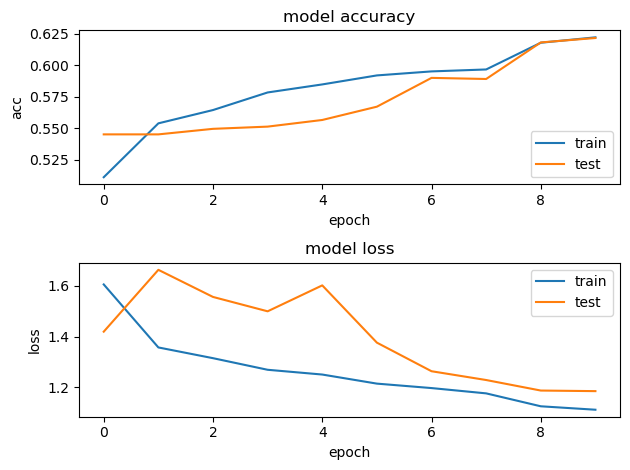

In [10]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()


In [11]:
model.evaluate(X_test, y_test.reshape((-1, 7)))

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - acc: 0.6122 - loss: 1.1563


[1.169708490371704, 0.6172080636024475]